In [599]:
import sys
import os
import requests
import datetime
from pathlib import Path
#
path_root = Path(os.path.abspath(''))
sys.path.insert(1, os.path.join(path_root))
#
path_root2 = Path(os.path.abspath('')).parent
sys.path.insert(1, os.path.join(path_root2))
import talib
import sqlite3 as sqlite3
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.font_manager as fm
from matplotlib import font_manager as fm, rcParams
from mplfinance.original_flavor import candlestick_ohlc
from util.util import get_ucodes
from scipy import stats

In [600]:
path_sqlite = os.path.join(path_root, 'data', 'aastock', 'sqlite', 'hk-marketwatch.db')
if not os.path.exists(path_sqlite):
    path_sqlite = os.path.join(path_root2, 'data', 'aastock', 'sqlite', 'hk-marketwatch.db')
print(path_sqlite)
conn = sqlite3.connect(path_sqlite)
cursor = conn.cursor()
conn.row_factory = lambda cursor, row: row[0]
no_days = 200
end_date = None

D:\PycharmProjects\scrapy-001\data\aastock\sqlite\hk-marketwatch.db


In [601]:
data1 = {}
ucodes = ['hsi', 'hsce', 'hstech', 'ssec', 'csi300', 'sp500', 'dji', 'ixic']
ucodes = ['02800', '03033', '02822']
#ucodes = ['09988', '01810', '03690', '00700']
for ucode in ucodes:
    sql = """SELECT t.code, t.lot, t.nmll, t.stime, t.high, t.low, t.open, t.close, t.volume
                FROM (SELECT n.code, n.lot, n.nmll, c.stime, c.high, c.low, c.open, c.close, c.volume 
                    FROM s_{} AS c INNER JOIN name AS n 
                        ON c.code=n.code ORDER BY c.stime DESC LIMIT {}) AS t 
                            ORDER BY t.stime """.format(ucode, no_days)
    cursor.execute(sql)
    columns = ['code', 'lot', 'nmll', 'sdate', 'high', 'low', 'open', 'last', 'vol']
    data1[ucode] = pd.DataFrame(cursor.fetchall(), columns=columns)
    data1[ucode].index = pd.to_datetime(data1[ucode].sdate)
    data1[ucode]['weekday'] = data1[ucode].index.dayofweek
    data1[ucode]['pchng'] = data1[ucode]['last'].pct_change()*100
    if end_date:
        mask = (data1[ucode].index <= end_date)
        data1[ucode] = data1[ucode].loc[mask]
conn.close()

In [602]:
url = 's_hk' + ',s_hk'.join(ucodes)
res1 = requests.get('https://qt.gtimg.cn/q='+url).content.decode('gb2312')
res2 = "".join(res1.split()).strip()
for v1 in filter(None, res2.split('v_s_hk')):
    v2 = v1.split('~')
    print(v2)
    last = float(v2[3])
    ucode = v2[2]
    name = v2[1]
    sdate = datetime.datetime.now().strftime("%Y-%m-%d")
    vol = float(v2[6])
    df3 = pd.DataFrame([[None,None,name,sdate,None, None, None,last,vol,None,None]], columns=['code','lot','nmll','sdate','high','low','open','last','vol','weekday','pchng'])
    df3.index = pd.to_datetime(df3.sdate)
    df3['weekday'] = df3.index.dayofweek
    data1[ucode] = pd.concat([data1[ucode], df3])
    data1[ucode] = data1[ucode][~data1[ucode].index.duplicated(keep='last')]

['02800="100', '盈富基金', '02800', '28.920', '-0.240', '-0.82', '40000.0', '1156800.000', '', '1004.3894";']
['03033="100', '南方恒生科技', '03033', '7.825', '-0.130', '-1.63', '60600.0', '474195.000', '', '0.0000";']
['02822="100', '南方A50', '02822', '19.450', '-0.070', '-0.36', '106000.0', '2061700.000', '', '160.0735";']


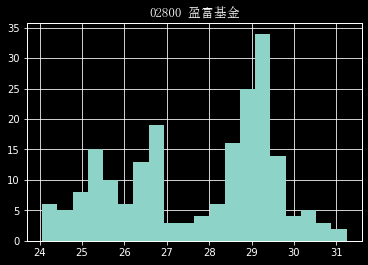

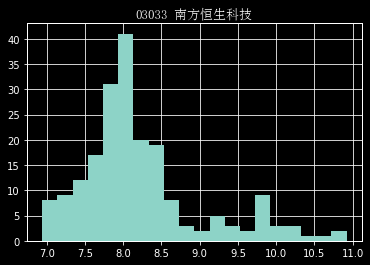

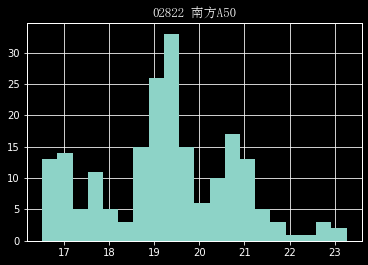

,ucode,nmll,nobs,min,25%,50%,mean,75%,max,skewness,kurtosis,sd
0,02800,盈富基金,201,24.06,26.30,28.40,27.70,29.200,31.24,-0.307146,-1.156818,1.806390
1,03033,南方恒生科技,199,6.94,7.78,8.06,8.23,8.425,10.92,1.228620,1.285542,0.796349
2,02822,南方A50,201,16.52,18.48,19.28,19.28,20.420,23.26,0.082621,-0.347744,1.494359


In [603]:
index = ['ucode', 'nmll', 'nobs', 'min', '25%', '50%', 'mean', '75%', 'max', 'skewness', 'kurtosis', 'sd']
fpath = os.path.join(rcParams["datapath"], "fonts/ttf/cmr10.ttf")
fpath = os.path.join('C:\Windows\Fonts', 'simsun.ttc')
prop = fm.FontProperties(fname=fpath)
df3 = pd.DataFrame(columns=index)
for ucode, df in data1.items():
    nmll = data1[ucode].iloc[-1]['nmll']
    d1 = stats.describe(df['last'].values)
    d2 = np.std(df['last'].values)
    d3 = df['last'].quantile([.0, .25, .5, .75, 1]).values.tolist()
    d4 = pd.Series([ucode, nmll, d1.nobs, d1.minmax[0], d3[1], d3[2], round(d1.mean, 2), d3[3], d1.minmax[1], d1.skewness, d1.kurtosis, d2], index=index)
    df3 = df3.append(d4, ignore_index=True)
    
    plt.title(ucode+' '+nmll, fontproperties=prop, fontsize=13)
    plt.style.use('dark_background')
    plt.hist(df['last'], bins=20)
    plt.show()
df3

In [605]:
no_spread = 30
data2 = {}
for ucode, df in data1.items():
    print('{}  {} ~ {}'.format(ucode, df.iloc[0].sdate, df.iloc[-1].sdate))
    data2[ucode] = pd.DataFrame(columns=['bottom', 'ceil', 'count', 'sdate', 'vol']) 
    max = df['last'].max()
    min = df['last'].min()
    spread = (max-min)/no_spread
    for i in range(0, no_spread):
        bottom = round(min + (spread*i), 2)
        ceil = round(min + (spread*(i+1)), 2)
        df2 = df.loc[(df['last'] >= bottom) & (df['last'] <= ceil)]
        count = df2.shape[0]
        sdate2 = df2['sdate'].values.tolist()
        vol = round(df.loc[(df['last'] >= bottom) & (df['last'] <= ceil)]['vol'].sum()/100000000, 3)
        data2[ucode].loc[len(data2[ucode])] = [bottom, ceil, count, ','.join(sdate2), vol]
print('-------------------------------------------------')

for ucode2, df2 in data2.items():
    row2 = data1[ucode2].iloc[-1]
    print(ucode2, row2['nmll'], row2['last'])
    df2["count"] = pd.to_numeric(df2["count"])
    n_larger = df2['vol'].nlargest(6).values.tolist()[::-1]
    spread = df2.iloc[0]['ceil'] - df2.iloc[0]['bottom']
    cum_vol = 0
    print('{}%  {}   {}'.format("{:.2f}".format(spread*10/row2['last']*100), 'aggr', 'nega'))
    for k, v in df2.iterrows():
        # 6大重倉標注
        remark = ''
        if v['vol'] in n_larger:
            remark = '<<'
            for i in range(0, n_larger.index(v['vol'])):
                remark += '--'
        # 現價
        remark2 = ''
        if row2['last'] >= v['bottom'] and row2['last'] < v['ceil']:
            remark2 = '现价'
        # 深度
        spread = v['ceil'] - v['bottom']
        p_bottom = spread/v['bottom']*100
        p_ceil = spread/v['ceil']*100
        # 分隔線
        if k%10 == 0 and k > 1:
            print('-------------------------------------------------')
        # 量1
        cum_vol += v['vol']
        remark3 = ''
        if str(k)[-1] == '9':
            remark3 = '('+str(round(cum_vol, 2))+'亿手)'
            cum_vol = 0
        #
        print('{}   | {}% ~ {}% | {} ~ {} | {}亿手 | {}  {} {} {}'.format(str(k+1).zfill(2), "{:.2f}".format(p_bottom), "{:.2f}".format(p_ceil), "{:.2f}".format(v['bottom']), "{:.2f}".format(v['ceil']), "{:.3f}".format(v['vol']), v['count'], remark, remark2, remark3))
    print('------------------------------------------------------------------')

02800  2020-08-26 ~ 2021-06-21
03033  2020-08-28 ~ 2021-06-21
02822  2020-08-26 ~ 2021-06-21
-------------------------------------------------
02800 盈富基金 28.92
8.30%  aggr   nega
01   | 1.00% ~ 0.99% | 24.06 ~ 24.30 | 4.967亿手 | 6    
02   | 0.99% ~ 0.98% | 24.30 ~ 24.54 | 2.375亿手 | 3    
03   | 0.98% ~ 0.97% | 24.54 ~ 24.78 | 2.132亿手 | 3    
04   | 0.97% ~ 0.96% | 24.78 ~ 25.02 | 3.259亿手 | 5    
05   | 0.96% ~ 0.95% | 25.02 ~ 25.26 | 4.994亿手 | 8    
06   | 0.95% ~ 0.94% | 25.26 ~ 25.50 | 6.938亿手 | 11    
07   | 0.94% ~ 0.93% | 25.50 ~ 25.74 | 5.606亿手 | 8    
08   | 0.89% ~ 0.89% | 25.74 ~ 25.97 | 3.825亿手 | 5    
09   | 0.92% ~ 0.92% | 25.97 ~ 26.21 | 2.064亿手 | 3    
10   | 0.92% ~ 0.91% | 26.21 ~ 26.45 | 6.279亿手 | 6    (42.44亿手)
-------------------------------------------------
11   | 0.91% ~ 0.90% | 26.45 ~ 26.69 | 16.888亿手 | 19  <<----  
12   | 0.90% ~ 0.89% | 26.69 ~ 26.93 | 7.767亿手 | 7    
13   | 0.89% ~ 0.88% | 26.93 ~ 27.17 | 2.839亿手 | 3    
14   | 0.88% ~ 0.88% | 27.17 ~ 27.41 |